In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import boost_histogram as bh
from numba import jit
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit
import time as ti
import pandas as pd
import scipy.stats as st
from scipy.optimize import least_squares


MEAN_FAIL_VALUE = 8415
STD_FAIL_VALUE = 0.05

PEAK_HEIGHT = 0.4
PEAK_SLOPE = 50

POINTS_BEGINNING = 1500
INDEX_DIFF = 1300

NEVENT = 1
MAX_ALLOWED_PEAK = 2

In [2]:
# Function for peak finding

def mean_start_finding_func(amp_arr):
    
    reshaped_array = np.reshape(amp_arr, (-1, 20))
    

    means = np.mean(reshaped_array, axis=1)
    
    for i in means:
        if i > i+0.1:
            idx = i
    
    return idx * 20



def peak_finding_func(data_x, data_y):
    signal_index_arr = []
    
    # Append 1 to this list, if any limits of the peak are reached
    delete_var = []
    
    # Finds the slope between two points and checks if it is negative
    # This is done to find the rough start of a peak
    
    def recursive_low_x(index):
        if (((data_y[index]-data_y[index-1])/(data_x[index]-data_x[index-1])) <= 0):
            idx = recursive_low_x(index-1)
        else:
            idx = index
        return idx
    
    # Recursively find peak point

    def peak_point(index):
        if index+1 >= 150:
            delete_var.append(1)
            return 150
        if ((((data_y[index]-data_y[index-1])/(data_x[index]-data_x[index-1])) <= 0) and 
            (((data_y[index+1]-data_y[index])/(data_x[index+1]-data_x[index])) >= 0)):
            peak_idx = index
        else:
            peak_idx = peak_point(index+1)
        return peak_idx
    
    # Recursively finds end of peak by checking slope again
    
    def recursive_high_x(index):
        if (((data_y[index+1]-data_y[index])/(data_x[index+1]-data_x[index])) >= 0):
            if index+1 >= 149:
                delete_var.append(1)
                return 150
            else:
                idx = recursive_high_x(index+1)
        else:
            idx = index+1
        return idx
    
    # Checks for a minimum slope and peak height in data and if found, sets the starting index to that
    # Otherwise the index was set to -1 and with this the event can be identified as background
    
    for i in range(len(data_x) - 1):
        if (abs((data_y[i+1]-data_y[i])/(data_x[i+1]-data_x[i])) > PEAK_SLOPE) and (abs(data_y[i+1] - data_y[i]) > PEAK_HEIGHT):
            index_var = i
            break
        else:
            index_var = -1
    
    if (index_var == -1):
        # Returns the signal index array, which is empty but does not delete the array from the data
        return signal_index_arr, []
    
    # Finds the peak with the previous functions and checks if the peak has to be deleted
    
    else:
        low_x_idx = recursive_low_x(index_var)
        peak_index_var = peak_point(index_var)
        if peak_index_var >= 149:
            delete_var.append(1)
            return signal_index_arr, delete_var
        high_x_idx = recursive_high_x(peak_index_var)
        signal_index_arr = np.arange(low_x_idx, high_x_idx)
        return signal_index_arr, delete_var

In [3]:
def background_average_iter_func(data_x, data_y, total_n_events):
    mean_arr = []
    std_arr = []
    delete_arr = []
    for i in range(total_n_events):
        if (i == NEVENT):
            bg_arr = []
            x = data_x
            y = data_y[i]
            plt.scatter(x,y, s=4)
            plt.plot(x[:POINTS_BEGINNING], y[:POINTS_BEGINNING], 'ro', markersize='1')
            plt.xlabel("Sample Time (ns)", fontsize = 25)
            plt.ylabel("ADC Value", fontsize = 25)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)
            plt.title("Event " + str(i) + ' original', fontsize = 30)
            # signal_arr_indicies, delete_var = peak_finding_func(x, y)
            # if len(delete_var) > 0:
            #     delete_arr.append(i)
            # plt.plot(x[signal_arr_indicies], y[signal_arr_indicies], color='orange', label='Identified signal')
            plt.legend()
            plt.show()
            bg_arr = data_y[i][:POINTS_BEGINNING]
            std_val = np.std(bg_arr)
            if std_val >= STD_FAIL_VALUE:
                delete_arr.append(i)
            # if (len(signal_arr_indicies) == 0):
            #     bg_arr.append(data_y[i])
            # else:
            #     bg_arr.append(data_y[i][np.arange(0, (signal_arr_indicies[0] - PEAK_BUFFER))])
            # bg_arr = np.array(bg_arr)
            # if (np.size(bg_arr) == 0):
            #     mean_arr.append(MEAN_FAIL_VALUE)
            #     std_arr.append(STD_FAIL_VALUE)
            # else:
            mean_arr.append(st.mode(bg_arr).mode[0])
            std_arr.append(std_val)
        else:
            if (i % 1000 == 0):
                print(i)
            bg_arr = []
            # signal_arr_indicies, delete_var = peak_finding_func(data_x, data_y[i])
            # if len(delete_var) > 0:
            #     delete_arr.append(i)
            # if (len(signal_arr_indicies) == 0):
            #     bg_arr.append(data_y[i])
            # else:
            #     bg_arr.append(data_y[i][np.arange(0, (signal_arr_indicies[0] - PEAK_BUFFER))])
            # bg_arr = np.array(bg_arr)
            # if (np.size(bg_arr) == 0):
            #     mean_arr.append(MEAN_FAIL_VALUE)
            #     std_arr.append(STD_FAIL_VALUE)
            # else:
            bg_arr = data_y[i][:POINTS_BEGINNING]
            std_val = np.std(bg_arr)
            if std_val >= STD_FAIL_VALUE:
                delete_arr.append(i)
            mean_arr.append(st.mode(bg_arr).mode[0])
            std_arr.append(std_val)

    mean_arr = np.array(mean_arr)
    std_arr = np.array(std_arr)
    return mean_arr, std_arr, delete_arr


def bin_pos_func(x_min, x_max, n_bins, p_per_bin):
    bin_width = p_per_bin * 2
    bin_loc_arr = np.linspace(x_min + bin_width / 2, x_max - bin_width / 2, n_bins)
    return bin_loc_arr

def number_of_bins_func(x, p_per_bin):
    return (len(x) - len(x) % p_per_bin) // p_per_bin


def binned_data(y, n_bins, p_per_bin):
    y = y[:n_bins * p_per_bin]
    return np.sum(y.reshape(-1, p_per_bin), axis=1)


In [4]:
@jit
def start_idx_func(y, thres):
    thres = thres*5
    for i in range(POINTS_BEGINNING, (len(y)-2-POINTS_BEGINNING)):
        if y[i] > thres:
            if y[i+1] > thres:
                if y[i+2] > thres:
                        idx_start = i-1
                        break
        if i == (len(y)-2-POINTS_BEGINNING-1):
            idx_start = (len(y)-2-POINTS_BEGINNING-1)
    return idx_start









@jit
def end_idx_func(y, thres):
    thres = thres*5
    # t_length = len(y)-1
    for i in range(POINTS_BEGINNING, (len(y)-2-POINTS_BEGINNING)):
        if y[i] > thres:
            if y[i+1] > thres:
                if y[i+2] > thres:
                        idx_start = i-1
                        break
        if i == (len(y)-2-POINTS_BEGINNING-1):
            idx_start = (len(y)-2-POINTS_BEGINNING-1)


    n_cut_idx = idx_start
    thres = thres/5
    y = y[(idx_start+3):]
    for i in range((len(y)-2)):
        if y[i] < thres:
            if y[i+1] < thres:
                if y[i+2] < thres:
                    idx_end = i + n_cut_idx
                    break
        if i == (len(y)-3):
            min_val = 2
            idx_end = 0

            for i in range(len(y)-3):
                if y[i] < min_val:
                    min_val = y[i]
                    idx_end = i + n_cut_idx
    return idx_end

def area_calc(x, y):
    return np.sum(y*2)


# Check if two lines are intersecting using angle logic.

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

# This function finds the intersection point, if the lines do intersect

def find_intersection_point(x1,y1,x2,y2,x3,y3,x4,y4):
    
    if ((x1-x2)*(y3-y4)) == (y1-y2)*(x3-x4):
        return [-100,-100]
    
    px= ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)) 
    py= ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
    
    return [px, py]


def FWHM_func(x, y, start_idx, end_idx, pp_bin):
    
    if (end_idx - start_idx) < 5:
        return -20
    
    
    fwhm_asymptote = np.max(y)/2

    def find_first_intersect(idx):
        if (idx <= 0):
            return idx + 1
        if (idx >= end_idx):
            return idx - 1
        if (y[idx] > fwhm_asymptote):
            return idx
        else:
            return find_first_intersect(idx+1)

    def find_second_intersect(idx):
        if (idx <= 0):
            return idx + 1
        if (idx >= end_idx):
            return idx - 1
        if (y[idx] > fwhm_asymptote):
            return idx
        else:
            return find_second_intersect(idx-1)

    first_upper_idx = find_first_intersect(start_idx)
    second_upper_idx = find_second_intersect(end_idx)
    first_lower_idx = first_upper_idx-1
    second_lower_idx = second_upper_idx+1
    
    FWHM_left = find_intersection_point(x[first_lower_idx], y[first_lower_idx], x[first_upper_idx], y[first_upper_idx]
                                        , x[0], fwhm_asymptote, x[-1], fwhm_asymptote)
    FWHM_right = find_intersection_point(x[second_lower_idx], y[second_lower_idx], x[second_upper_idx], y[second_upper_idx]
                                         , x[0], fwhm_asymptote, x[-1], fwhm_asymptote)

    return FWHM_right[0] - FWHM_left[0]

Trying to open files ...
Opened files
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


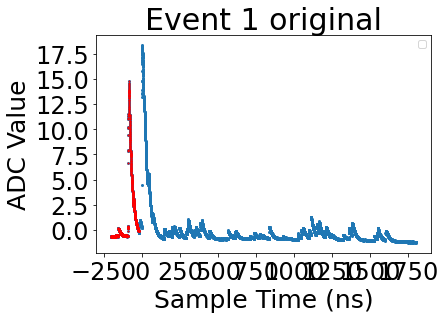

1000
2000
3000
4000
5000
6000
Past bg iter func
16666


In [5]:


# Main Code

avg_background_value = 8400

# https://stackoverflow.com/questions/52782965/pythonic-way-to-determine-width-of-plot

print("Trying to open files ...")

# Viewing particular event of particular file.
# Open the data, apply to variable
# file = "E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Run203-PMT107.root"
# file = "E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Boulby_107_Signal.root"



# tree = uproot.open(file)["Tree;4"]
# branches = tree.arrays()
# how long between data taken
# timegate = 2
# # length of event
# eventlen = len(branches['ADC'][0])
# time = []
# # Creating list for sample times that are 2ns intervals, 150 samples
# for i in range(eventlen):
#     time.append(i*timegate)

# total_n_events = 10000

# df = pd.read_hdf('E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Calibration\data_alpha_gas_undoped_night_V1.h5', key='mydata')
df = pd.read_hdf('E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Calibration\data_alpha_V1.h5', key='mydata')

# time_arr = []
# for i in range(total_n_events):
#     time_arr.append(time)

# time_arr = np.array(time_arr)


# branch_arr = np.array(branches['ADC'])
# branch_len = len(branch_arr)


# Input event
Nevent = 6
PEAK_BUFFER = 15

x_arr = df['Time'].values


y_arr = []

for column in df.columns[1:]:
    # extract the data of the column as a numpy array and append it to the list
    y_arr.append(df[column].values)



total_n_events = len(y_arr)
# total_n_events = 1000

print('Opened files')


mean_arr_temp, std_arr_0, delete_arr = background_average_iter_func(x_arr, y_arr, total_n_events)
print('Past bg iter func')


y_arr = np.delete(y_arr, delete_arr, axis=0)
mean_arr_temp = np.delete(mean_arr_temp, delete_arr, axis=0)
std_arr_0 = np.delete(std_arr_0, delete_arr, axis=0)

total_n_events = len(y_arr)

# Flip and centre data at y = 0

for i in range(total_n_events):
    y_arr[i] = (y_arr[i] - mean_arr_temp[i])



# plt.plot(x_arr, y_arr[Nevent])
# plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_temp[Nevent], std_arr_temp[Nevent]], '--', color='red')
# plt.plot([np.min(x_arr), np.max(x_arr)], [0, 0], '--', color='black')
# plt.plot([np.min(x_arr), np.max(x_arr)], [-std_arr_temp[Nevent], -std_arr_temp[Nevent]], '--', color='red')
# plt.show()

bin_arr_2 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 2), 2)
# bin_arr_3 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 3), 3)
# bin_arr_4 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 4), 4)
# bin_arr_5 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 5), 5)
# bin_arr_6 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 6), 6)
# bin_arr_7 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 7), 7)
# bin_arr_8 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 8), 8)

binned_adc_2 = [[]]
# binned_adc_3 = [[]]
# binned_adc_4 = [[]]
# binned_adc_5 = [[]]
# binned_adc_6 = [[]]
# binned_adc_7 = [[]]
# binned_adc_8 = [[]]


for i in range(total_n_events):
    binned_adc_2.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 2), 2))
    # binned_adc_3.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 3), 3))
    # binned_adc_4.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 4), 4))
    # binned_adc_5.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 5), 5))
    # binned_adc_6.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 6), 6))
    # binned_adc_7.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 7), 7))
    # binned_adc_8.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 8), 8))

binned_adc_2 = np.array(binned_adc_2[1:])
# binned_adc_3 = np.array(binned_adc_3[1:])
# binned_adc_4 = np.array(binned_adc_4[1:])
# binned_adc_5 = np.array(binned_adc_5[1:])
# binned_adc_6 = np.array(binned_adc_6[1:])
# binned_adc_7 = np.array(binned_adc_7[1:])
# binned_adc_8 = np.array(binned_adc_8[1:])


std_arr_2 = []
# std_arr_3 = []
# std_arr_4 = []
# std_arr_5 = []
# std_arr_6 = []
# std_arr_7 = []
# std_arr_8 = []

for i in range(total_n_events):
    std_arr_2.append(np.sqrt(2) * std_arr_0[i])
    # std_arr_3.append(np.sqrt(3) * std_arr_0[i])
    # std_arr_4.append(np.sqrt(4) * std_arr_0[i])
    # std_arr_5.append(np.sqrt(5) * std_arr_0[i])
    # std_arr_6.append(np.sqrt(6) * std_arr_0[i])
    # std_arr_7.append(np.sqrt(7) * std_arr_0[i])
    # std_arr_8.append(np.sqrt(8) * std_arr_0[i])


std_arr_2 = np.array(std_arr_2)
# std_arr_3 = np.array(std_arr_3)
# std_arr_4 = np.array(std_arr_4)
# std_arr_5 = np.array(std_arr_5)
# std_arr_6 = np.array(std_arr_6)
# std_arr_7 = np.array(std_arr_7)
# std_arr_8 = np.array(std_arr_8)


# plt.plot(x_arr, y_arr[Nevent], label='No bins')
# plt.plot(bin_arr_2, binned_adc_2, label='2 points per bin')
# plt.plot(bin_arr_3, binned_adc_3, label='3 points per bin')
# plt.plot(bin_arr_4, binned_adc_4, label='4 points per bin')
# plt.plot(bin_arr_5, binned_adc_5, label='5 points per bin')
# plt.plot(bin_arr_6, binned_adc_6, label='6 points per bin')
# plt.legend()
# plt.show()

starting_index_bin_0 = []
starting_index_bin_2 = []
# starting_index_bin_3 = []
# starting_index_bin_4 = []
# starting_index_bin_5 = []
# starting_index_bin_6 = []
# starting_index_bin_7 = []
# starting_index_bin_8 = []

ending_index_bin_0 = []
ending_index_bin_2 = []
# ending_index_bin_3 = []
# ending_index_bin_4 = []
# ending_index_bin_5 = []
# ending_index_bin_6 = []
# ending_index_bin_7 = []
# ending_index_bin_8 = []



for i in range(total_n_events):
    starting_index_bin_0.append(start_idx_func(y_arr[i], std_arr_0[i]))
    ending_index_bin_0.append(end_idx_func(y_arr[i], std_arr_0[i]))
    starting_index_bin_2.append(start_idx_func(binned_adc_2[i], std_arr_2[i]))
    ending_index_bin_2.append(end_idx_func(binned_adc_2[i], std_arr_2[i]))
    # starting_index_bin_3.append(start_idx_func(binned_adc_3[i], std_arr_3[i]))
    # ending_index_bin_3.append(end_idx_func(binned_adc_3[i], std_arr_3[i]))
    # starting_index_bin_4.append(start_idx_func(binned_adc_4[i], std_arr_4[i]))
    # ending_index_bin_4.append(end_idx_func(binned_adc_4[i], std_arr_4[i]))
    # starting_index_bin_5.append(start_idx_func(binned_adc_5[i], std_arr_5[i]))
    # ending_index_bin_5.append(end_idx_func(binned_adc_5[i], std_arr_5[i]))
    # starting_index_bin_6.append(start_idx_func(binned_adc_6[i], std_arr_6[i]))
    # ending_index_bin_6.append(end_idx_func(binned_adc_6[i], std_arr_6[i]))
    # starting_index_bin_7.append(start_idx_func(binned_adc_7[i], std_arr_7[i]))
    # ending_index_bin_7.append(end_idx_func(binned_adc_7[i], std_arr_7[i]))
    # starting_index_bin_8.append(start_idx_func(binned_adc_8[i], std_arr_8[i]))
    # ending_index_bin_8.append(end_idx_func(binned_adc_8[i], std_arr_8[i]))

index_del_arr = []
for i in range(total_n_events):
    if np.abs(ending_index_bin_0[i]-starting_index_bin_0[i]) > INDEX_DIFF:
        index_del_arr.append(i)


y_arr = np.delete(y_arr, index_del_arr, axis=0)

mean_arr_temp = np.delete(mean_arr_temp, index_del_arr, axis=0)
std_arr_0 = np.delete(std_arr_0, index_del_arr, axis=0)
binned_adc_2 = np.delete(binned_adc_2, index_del_arr, axis=0)


starting_index_bin_0 = np.array(starting_index_bin_0)
starting_index_bin_2 = np.array(starting_index_bin_2)
# starting_index_bin_3 = np.array(starting_index_bin_3)
# starting_index_bin_4 = np.array(starting_index_bin_4)
# starting_index_bin_5 = np.array(starting_index_bin_5)
# starting_index_bin_6 = np.array(starting_index_bin_6)
# starting_index_bin_7 = np.array(starting_index_bin_7)
# starting_index_bin_8 = np.array(starting_index_bin_8)

ending_index_bin_0 = np.array(ending_index_bin_0)
ending_index_bin_2 = np.array(ending_index_bin_2)
# ending_index_bin_3 = np.array(ending_index_bin_3)
# ending_index_bin_4 = np.array(ending_index_bin_4)
# ending_index_bin_5 = np.array(ending_index_bin_5)
# ending_index_bin_6 = np.array(ending_index_bin_6)
# ending_index_bin_7 = np.array(ending_index_bin_7)
# ending_index_bin_8 = np.array(ending_index_bin_8)


starting_index_bin_0 = np.delete(starting_index_bin_0, index_del_arr, axis=0)
ending_index_bin_0 = np.delete(ending_index_bin_0, index_del_arr, axis=0)
starting_index_bin_2 = np.delete(starting_index_bin_2, index_del_arr, axis=0)
ending_index_bin_2 = np.delete(ending_index_bin_2, index_del_arr, axis=0)

total_n_events = len(y_arr)

print(len(x_arr))

In [6]:
# delete_second_peak_arr = []



# for i in range(total_n_events):
#     bool_arr = (y_arr[i][ending_index_bin_0[i]:]) > MAX_ALLOWED_PEAK
#     if bool_arr.any():
#         delete_second_peak_arr.append(i)
#         print(i)
#     else:
#         continue



# y_arr = np.delete(y_arr, delete_second_peak_arr, axis=0)
# mean_arr_temp = np.delete(mean_arr_temp, delete_second_peak_arr, axis=0)
# std_arr_0 = np.delete(std_arr_0, delete_second_peak_arr, axis=0)
# starting_index_bin_0 = np.delete(starting_index_bin_0, delete_second_peak_arr, axis=0)
# ending_index_bin_0 = np.delete(ending_index_bin_0, delete_second_peak_arr, axis=0)
# total_n_events = len(y_arr)
print(len(y_arr))

3659


In [7]:
print(len(y_arr))

3659


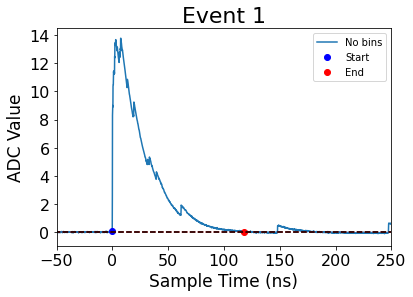

In [8]:
Nevent = 1

plt.plot(x_arr, y_arr[Nevent], label='No bins')
plt.plot(x_arr[starting_index_bin_0[Nevent]], y_arr[Nevent][starting_index_bin_0[Nevent]], 'bo', label='Start')
plt.plot(x_arr[ending_index_bin_0[Nevent]], y_arr[Nevent][ending_index_bin_0[Nevent]], 'ro', label='End')
plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_0[Nevent], std_arr_0[Nevent]], '--', color='red')
plt.plot([np.min(x_arr), np.max(x_arr)], [0, 0], '--', color='black')
plt.xlabel("Sample Time (ns)", fontsize = 17)
plt.ylabel("ADC Value", fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-50, 250)
plt.title("Event " + str(Nevent), fontsize = 22)
plt.legend()
plt.show()

In [9]:
# heigh_del_arr = []
# MIN_HEIGHT = 10

# for i in range(total_n_events):
#     if not ((y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]]).any() > MIN_HEIGHT):
#         heigh_del_arr.append(i)



# total_n_events = len(y_arr)

3659


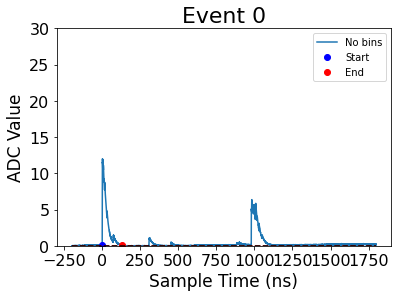

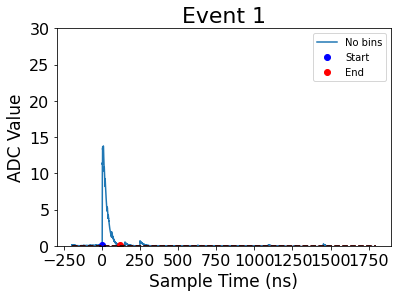

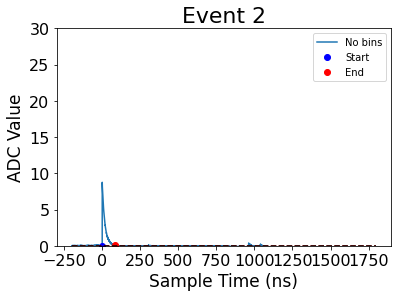

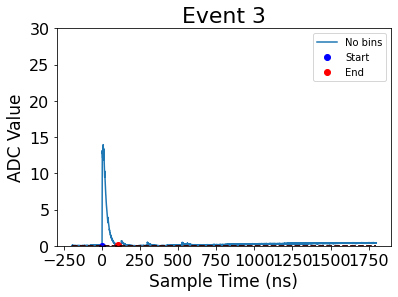

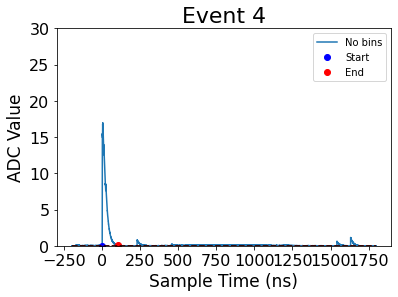

In [10]:
Nevent = 5
print(total_n_events)
# print(starting_index_bin_0[Nevent], ending_index_bin_0[Nevent])
# print(np.sum(y_arr[Nevent][starting_index_bin_0[Nevent]:ending_index_bin_0[Nevent]]))

for Nevent in range(5):
    plt.plot(x_arr, y_arr[Nevent], label='No bins')
    plt.plot(x_arr[starting_index_bin_0[Nevent]], y_arr[Nevent][starting_index_bin_0[Nevent]], 'bo', label='Start')
    plt.plot(x_arr[ending_index_bin_0[Nevent]], y_arr[Nevent][ending_index_bin_0[Nevent]], 'ro', label='End')
    plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_0[Nevent], std_arr_0[Nevent]], '--', color='red')
    plt.plot([np.min(x_arr), np.max(x_arr)], [0, 0], '--', color='black')
    plt.xlabel("Sample Time (ns)", fontsize = 17)
    plt.ylabel("ADC Value", fontsize = 17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Event " + str(Nevent), fontsize = 22)
    plt.ylim(0, 30)
    plt.legend()
    plt.show()



In [11]:
# def quadratic_func(a, b, d, x):
#     return (a * (x + d)**2 + (x + d) * b)/100000

# def func_to_mini(vars, x, y):
#     a, b = vars
#     return st.mode(y - quadratic_func(a, b, -x[0], x)).mode[0]

# guess = np.array([-0.0066,31])
# answer = least_squares(func_to_mini, guess, args=(x_arr[ending_index_bin_0[Nevent]:], y_arr[Nevent][ending_index_bin_0[Nevent]:]))

# a, b = answer.x
# print(answer.x)
# plt.plot(x_arr, y_arr[Nevent])
# plt.plot(x_arr[ending_index_bin_0[Nevent]:], quadratic_func(a, b, x_arr[ending_index_bin_0[Nevent]], x_arr[ending_index_bin_0[Nevent]:]))
# plt.show()




In [12]:

# # def combined_func(a, b, c, x, end_point):
# #     y1 = c * (np.log(x+b)/a)
# #     y2 = 0 * x +0
# #     y = np.where(x >= end_point, y1, y2)
# #     return y

# def combined_func(a, b, c, x, end_point):
#     return a* np.sin(b*(x+c))

# def func_to_mini(vars, x, y, end_point):
#     a, b,c = vars
#     return st.mode(y - combined_func(a, b,c, x, end_point)).mode[0]
# # bounds = ([0.1, 0.1, 0.1], [np.inf, np.inf, np.inf])
# guess = np.array([1,150, (1750/np.pi)])
# answer = least_squares(func_to_mini, guess, args=(x_arr[ending_index_bin_0[4]:], y_arr[4][ending_index_bin_0[4]:], x_arr[ending_index_bin_0[4]]))


# print(answer.x)
# a, b,c = answer.x

# plt.plot(x_arr, y_arr[4])
# plt.plot(x_arr[ending_index_bin_0[4]:], combined_func(a, b, c,x_arr[ending_index_bin_0[4]:], x_arr[ending_index_bin_0[4]]))
# plt.show()

In [13]:
bin_area_0 = []
bin_area_2 = []
# bin_area_3 = []
# bin_area_4 = []
# bin_area_5 = []
# bin_area_6 = []
# bin_area_7 = []
# bin_area_8 = []



for i in range(total_n_events):
    bin_area_0.append(area_calc(x_arr[starting_index_bin_0[i]:ending_index_bin_0[i]]
                                , y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]]))
    bin_area_2.append(area_calc(bin_arr_2[starting_index_bin_2[i]:ending_index_bin_2[i]]
                                , binned_adc_2[i][starting_index_bin_2[i]:ending_index_bin_2[i]]))
    # bin_area_3.append(area_calc(bin_arr_3[starting_index_bin_3[i]:ending_index_bin_3[i]]
    #                             , binned_adc_3[i][starting_index_bin_3[i]:ending_index_bin_3[i]]))
    # bin_area_4.append(area_calc(bin_arr_4[starting_index_bin_4[i]:ending_index_bin_4[i]]
    #                             , binned_adc_4[i][starting_index_bin_4[i]:ending_index_bin_4[i]]))
    # bin_area_5.append(area_calc(bin_arr_5[starting_index_bin_5[i]:ending_index_bin_5[i]]
    #                             , binned_adc_5[i][starting_index_bin_5[i]:ending_index_bin_5[i]]))
    # bin_area_6.append(area_calc(bin_arr_6[starting_index_bin_6[i]:ending_index_bin_6[i]]
    #                             , binned_adc_6[i][starting_index_bin_6[i]:ending_index_bin_6[i]]))
    # bin_area_7.append(area_calc(bin_arr_7[starting_index_bin_7[i]:ending_index_bin_7[i]]
    #                             , binned_adc_7[i][starting_index_bin_7[i]:ending_index_bin_7[i]]))
    # bin_area_8.append(area_calc(bin_arr_8[starting_index_bin_8[i]:ending_index_bin_8[i]]
    #                             , binned_adc_8[i][starting_index_bin_8[i]:ending_index_bin_8[i]]))




# plt.plot(bin_arr_4, binned_adc_4[Nevent], label='4 points per bin')
# plt.plot(bin_arr_4[starting_index_bin_4[Nevent]], binned_adc_4[Nevent][starting_index_bin_4[Nevent]], 'ro')
# plt.plot(bin_arr_4[ending_index_bin_4[Nevent]], binned_adc_4[Nevent][ending_index_bin_4[Nevent]], 'ro')
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()


# plt.plot(bin_arr_8, binned_adc_8[Nevent], label='8 points per bin')
# plt.plot(bin_arr_8[starting_index_bin_8[Nevent]], binned_adc_8[Nevent][starting_index_bin_8[Nevent]], 'ro')
# plt.plot(bin_arr_8[ending_index_bin_8[Nevent]], binned_adc_8[Nevent][ending_index_bin_8[Nevent]], 'ro')
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()




bin_area_0 = np.array(bin_area_0)
bin_area_2 = np.array(bin_area_2)
# bin_area_3 = np.array(bin_area_3)
# bin_area_4 = np.array(bin_area_4)
# bin_area_5 = np.array(bin_area_5)
# bin_area_6 = np.array(bin_area_6)
# bin_area_7 = np.array(bin_area_7)
# bin_area_8 = np.array(bin_area_8)


# p_per_bin_arr = [1, 2, 3, 4, 5, 6, 7, 8]
# area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_5[Nevent]
#             , bin_area_6[Nevent], bin_area_7[Nevent], bin_area_8[Nevent]]

# # p_per_bin_arr = [1, 2, 3, 4, 6]
# # area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_6[Nevent]]


# plt.scatter(p_per_bin_arr, area_arr)
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()


# fwhm_arr_0 = []
# fwhm_arr_2 = []
# # fwhm_arr_3 = []
# # fwhm_arr_4 = []
# # fwhm_arr_5 = []
# # fwhm_arr_6 = []
# # fwhm_arr_7 = []
# # fwhm_arr_8 = []


# print('Before FWHM')

# start_new_time = ti.time()

# for i in range(total_n_events):
#     fwhm_arr_0.append(FWHM_func(x_arr, y_arr[i], starting_index_bin_0[i], ending_index_bin_0[i], 1))
#     fwhm_arr_2.append(FWHM_func(bin_arr_2, binned_adc_2[i], starting_index_bin_2[i], ending_index_bin_2[i], 2))
#     # fwhm_arr_3.append(FWHM_func(bin_arr_3, binned_adc_3[i], starting_index_bin_3[i], ending_index_bin_3[i], 3))
#     # fwhm_arr_4.append(FWHM_func(bin_arr_4, binned_adc_4[i], starting_index_bin_4[i], ending_index_bin_4[i], 4))
#     # fwhm_arr_5.append(FWHM_func(bin_arr_5, binned_adc_5[i], starting_index_bin_5[i], ending_index_bin_5[i], 5))
#     # fwhm_arr_6.append(FWHM_func(bin_arr_6, binned_adc_6[i], starting_index_bin_6[i], ending_index_bin_6[i], 6))
#     # fwhm_arr_7.append(FWHM_func(bin_arr_7, binned_adc_7[i], starting_index_bin_7[i], ending_index_bin_7[i], 7))
#     # fwhm_arr_8.append(FWHM_func(bin_arr_8, binned_adc_8[i], starting_index_bin_8[i], ending_index_bin_8[i], 8))

# fwhm_arr_0 = np.array(fwhm_arr_0)
# fwhm_arr_2 = np.array(fwhm_arr_2)
# # fwhm_arr_3 = np.array(fwhm_arr_3)
# # fwhm_arr_4 = np.array(fwhm_arr_4)
# # fwhm_arr_5 = np.array(fwhm_arr_5)
# # fwhm_arr_6 = np.array(fwhm_arr_6)
# # fwhm_arr_7 = np.array(fwhm_arr_7)
# # fwhm_arr_8 = np.array(fwhm_arr_8)




# end_new_time = ti.time()



# plt.hist(fwhm_arr_0, bins=100)
# plt.show()


# Define data

# x_axis_arr = [1, 2, 3, 4, 5, 6, 7, 8]
# y_area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_5[Nevent], bin_area_6[Nevent], bin_area_7[Nevent], bin_area_7[Nevent]]
# y_fwhm_arr = [fwhm_arr_0[Nevent], fwhm_arr_2[Nevent], fwhm_arr_3[Nevent], fwhm_arr_4[Nevent], fwhm_arr_5[Nevent], fwhm_arr_6[Nevent], fwhm_arr_7[Nevent], fwhm_arr_8[Nevent]]










# # Create Plot

# fig, ax1 = plt.subplots() 


  
# ax1.set_xlabel('Points per bin') 
# ax1.set_ylabel('Area', color = 'black') 
# plot_1 = ax1.plot(x_axis_arr, y_area_arr, color = 'black') 
# ax1.tick_params(axis ='y', labelcolor = 'black') 

# # Adding Twin Axes

# ax2 = ax1.twinx() 
  
# ax2.set_ylabel('FWHM', color = 'green') 
# plot_2 = ax2.plot(x_axis_arr, y_fwhm_arr, color = 'green') 
# ax2.tick_params(axis ='y', labelcolor = 'green') 

# # Show plot

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)

# plt.show()


# adc_values_photo_peak_arr = []

# for i in range(total_n_events):
#     # if (fwhm_arr_0[i] > 5) and (fwhm_arr_0[i] < 10):
#         adc_values_photo_peak_arr.append(y_arr[i])


# adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)
# print(adc_values_photo_peak_arr)

# plt.hist(adc_values_photo_peak_arr)
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()



# def _flatten(values):
#     if isinstance(values, np.ndarray):
#         yield values.flatten()
#     else:
#         for value in values:
#             yield from _flatten(value)

# def flatten(values):
#     # flatten nested lists of np.ndarray to np.ndarray
#     return np.concatenate(list(_flatten(values)))

# adc_values_photo_peak_arr = []

# for i in range(total_n_events):
#     if fwhm_arr_0[i] > 5:
#         adc_values_photo_peak_arr.append(y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]])


# adc_values_photo_peak_arr = flatten(adc_values_photo_peak_arr)

# adc_values_photo_peak_arr = [i for i in adc_values_photo_peak_arr if i < 200]

# adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)


# plt.hist(adc_values_photo_peak_arr, bins=500)
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


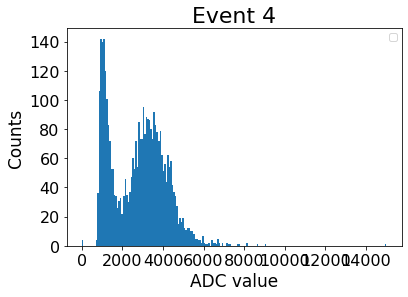

Here


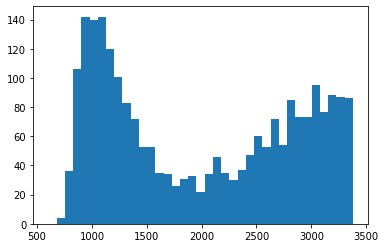

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-5.11783607e+00  3.65214702e+03 -1.15790012e+00  6.39189189e+01]


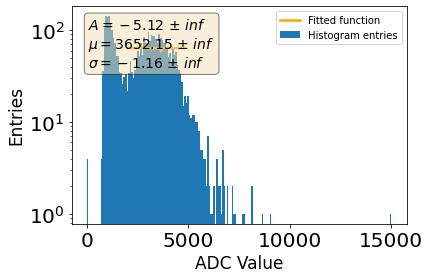

In [14]:

def gauss(x, A, x0, sigma, H):
    return (A * np.exp(- (((x - x0)**2))/(2 * (sigma**2)))) + H


MIN_SUM = 0
adc_values_photo_peak_arr = []
correct_wf_arr = []

for i in range(total_n_events):
    # if fwhm_arr_2[i] > 0:
    sum_var = np.sum(y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]])
    if sum_var > MIN_SUM:
        correct_wf_arr.append(i)
        adc_values_photo_peak_arr.append(sum_var)


# for i in range(1): 
#     plt.plot(x_arr, y_arr[correct_wf_arr[i]])
#     plt.show()


adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)
n, bin_edges, patches = plt.hist(adc_values_photo_peak_arr, bins=200)
plt.xlabel("ADC value", fontsize = 17)
plt.ylabel("Counts", fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Event " + str(Nevent), fontsize = 22)
plt.legend()
plt.show()


plt.show()

print('Here')

bins_centres = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

# plt.bar(bins_centres[5:30], n[5:30], width=(bin_edges[1] - bin_edges[0]))
# plt.show()

plt.bar(bins_centres[8:45], n[8:45], width=(bin_edges[1] - bin_edges[0]))
plt.show()

popt, pcov = curve_fit(gauss, xdata=bins_centres[8:45], ydata=n[8:45], p0=[60, 3300, 900, 3000])
print(popt)
perr = np.sqrt(np.diag(pcov))


xspace = np.linspace(2000, 4800, 100000)





fig, ax = plt.subplots()

ax.bar(bins_centres, n, width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(xspace, gauss(xspace, *popt), color='orange', linewidth=2.5, label=r'Fitted function')


ax.set_xlabel("ADC Value", fontsize = 17)
ax.set_ylabel("Entries", fontsize = 17)
ax.tick_params(axis='x', which='both', labelsize=20)
ax.tick_params(axis='y', which='both', labelsize=20)

textstr = '\n'.join((
    r'$A=%.2f$ $\pm~%.3f$' % (popt[0], perr[0], ),
    r'$\mu=%.2f$ $\pm~%.3f$' % (popt[1], perr[1], ),
    r'$\sigma=%.2f$ $\pm~%.3f$' % (popt[2], perr[2], )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_yscale("log")
# ax.set_xlim(0, 200)

# ax.title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f$' %(popt[0],popt[1],popt[2]), fontsize = 22)
ax.legend()
plt.show()

C:\Users\Marc\AppData\Local\Temp\ipykernel_4556\294053072.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


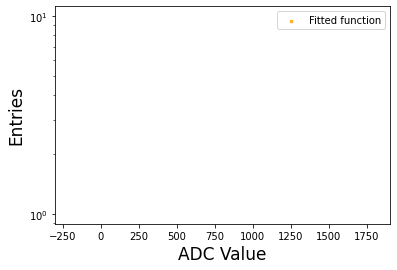

In [15]:
last_y_arr = np.delete(y_arr, correct_wf_arr, axis=0)
summed_y = np.sum(last_y_arr, axis=0)
# summed_y = summed_y+20


fig, ax = plt.subplots()
ax.scatter(x_arr, summed_y, color='orange', linewidth=2.5, label=r'Fitted function', s=1)
ax.set_xlabel("ADC Value", fontsize = 17)
ax.set_ylabel("Entries", fontsize = 17)

ax.set_yscale("log")
ax.legend()
plt.show()


570647972.4800955


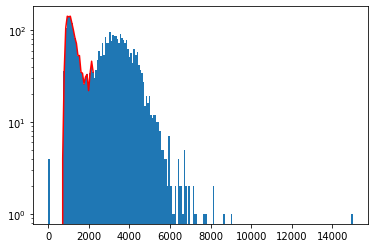

[1.18422117e+02 1.07904571e+03 1.73910448e+02 3.00731718e+01
 2.02015641e+10]
[1.33893323e+01 2.02082390e+01 3.60486596e+01 2.77039283e+01
 1.10655303e+17]
(128.66387197640464, 7.568463057435567)


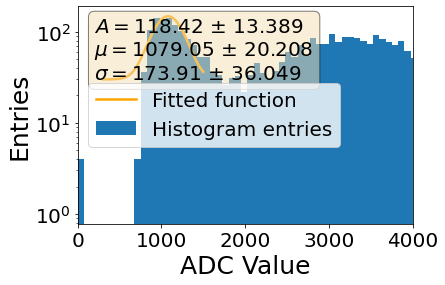

In [16]:










G = (popt[1]* 25 * 10**(-15))/(1.6*10**(-19))
print(G)

fig, ax = plt.subplots()

ax.bar(bins_centres, n, width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(bins_centres[5:30], n[5:30], c='r')
ax.set_yscale("log")
plt.show()



x_fitting_data = bins_centres[8:30]
y_fitting_data = n[8:30]

# def combined_func(x, amplitude_gaussian, mean_gaussian, sigma_gaussian,amplitude_exp1, decay_exp1,amplitude_exp2, decay_exp2):
#     return (amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * (sigma_gaussian ** 2))) + amplitude_exp1 * np.exp(-x / decay_exp1) 
#             + amplitude_exp2 * np.exp(-x / decay_exp2))

def combined_func(x, amplitude_gaussian, mean_gaussian, sigma_gaussian,amplitude_exp1, decay_exp1):
    return (amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * (sigma_gaussian ** 2))) + amplitude_exp1 * np.exp(-x / decay_exp1))



def fit_gauss_2exps(x, y, p0):
    popt, pcov = curve_fit(combined_func, x, y, p0)
    return popt, pcov

# guess = [1200, 1450, 421, 980, 445, 400, 10]
guess = [192, 897, 262, 129, 1442]

popt, pcov = fit_gauss_2exps(x_fitting_data, y_fitting_data, guess)


perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr)

def chi_squared(x_data, y_data, param, func):
    yfit = func(x_data, *param)
    residuals = y_data - yfit
    chisq = np.sum((residuals)**2/yfit)
    dof = len(y_data) - len(param)
    redchisq = chisq / dof
    return chisq, redchisq

print(chi_squared(x_fitting_data, y_fitting_data, popt, combined_func))





xspace = np.linspace(300, 1500, 1000)

fig, ax = plt.subplots()

ax.bar(bins_centres[:], n[:], width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(xspace, combined_func(xspace, *popt), color='orange', linewidth=2.5, label=r'Fitted function')

ax.set_xlabel("ADC Value", fontsize = 25)
ax.set_ylabel("Entries", fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=20)


textstr = '\n'.join((
    r'$A=%.2f$ $\pm~%.3f$' % (popt[0], perr[0], ),
    r'$\mu=%.2f$ $\pm~%.3f$' % (popt[1], perr[1], ),
    r'$\sigma=%.2f$ $\pm~%.3f$' % (popt[2], perr[2], )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
ax.set_yscale("log")
ax.set_xlim([0, 4000])
ax.legend(fontsize='20')
plt.show()

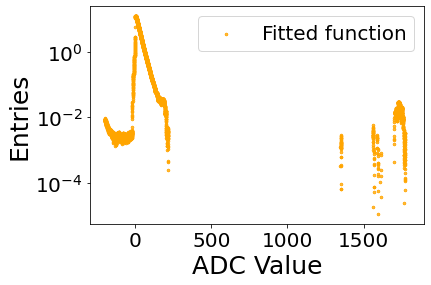

In [17]:
y_summed = np.sum(y_arr, axis=0)
y_summed = y_summed/len(y_arr)


fig, ax = plt.subplots()


ax.scatter(x_arr, y_summed, color='orange', linewidth=2.5, label=r'Fitted function', s=1)

ax.set_xlabel("ADC Value", fontsize = 25)
ax.set_ylabel("Entries", fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=20)



ax.set_yscale("log")
# ax.set_xlim([150, 2000])
ax.legend(fontsize='20')
plt.show()
